In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import scipy.optimize

In [2]:
ke2 = 197 / 137 # eV-nm   Coulomb force charge
alpha = 1.09e3  # eV      parameter of model
rho = 0.0321    # nm      parameter of model
b = 1.0         # eV      regular
c = 0.01        # nm

In [3]:
def cp(l):
    return np.fromiter(itertools.chain(*itertools.combinations(l,2)),dtype=int).reshape(-1,2)

class Cluster:
    def __init__(self, r_na, r_cl):
        '''
        Inputs the list of Na and Cl positions. Na has charge +1, Cl has -1.
        The array of ions itself does not change throughout the calculation, and
        neither do the charges. As such, we can just compute the combinations one time
        and refer to it throughout the calculation.
        '''
        self.positions = np.concatenate( (r_na,r_cl))
        self.charges = np.concatenate( [np.ones(r_na.shape[0]), np.full(r_cl.shape[0], -1)] )
        self.combs = cp(np.arange(self.charges.size))
        self.chargeprods = self.charges[self.combs][:,0] * self.charges[self.combs][:,1]
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)

    def Vij(self):
        '''Calculate a numpy vector of all of the potentials of the combinations'''
        self.Vij_ = np.zeros_like(self.rij)
        pos = self.chargeprods>0
        neg = ~pos
        self.Vij_[pos] = ke2 / self.rij[pos] + b*(c/self.rij[pos])**12
        self.Vij_[neg] =-ke2 / self.rij[neg] + alpha*np.exp(-self.rij[neg]/rho) + b*(c/self.rij[neg])**12
        return self.Vij_

    def V(self):
        '''Total potential, which is a sum of the Vij vector'''
        return np.sum(self.Vij())

    def get_vals(self):
        '''Positions interpreted as a flat shape'''
        return np.reshape(self.positions, -1)

    def set_vals(self, vals ):
        '''Inputs flat shape of positions, used by __call__'''
        self.positions = vals.reshape(self.positions.shape)
        self.rij = np.linalg.norm(self.positions[self.combs][:,0] - self.positions[self.combs][:,1], axis=1)


    def __call__(self, vals):
        '''Function that  scipy.optimize.minimize will call'''
        self.set_vals(vals)
        return self.V()

# **Run the simulation for Rectangular Shaped configuration**

<img src="https://github.com/Mosaddeq107/23-Homework7G5/blob/main/Images/rectagle.png?raw=true" style="height:300px" />

## Guessing and setting the initial position of Na and Cl

In [8]:
a = 0.2

r_na = np.array([ [0,0,0], [2*a,-0.2*a,0], [3*a,a,0], [a,1.2*a,0] ])
r_cl = np.array([ [a,-0.2*a,0], [3*a,0,0], [2*a,1.2*a,0], [0,a,0] ])

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

initial Na positions:
 [[ 0.    0.    0.  ]
 [ 0.4  -0.04  0.  ]
 [ 0.6   0.2   0.  ]
 [ 0.2   0.24  0.  ]]
initial Cl positions:
 [[ 0.2  -0.04  0.  ]
 [ 0.6   0.    0.  ]
 [ 0.4   0.24  0.  ]
 [ 0.    0.2   0.  ]]
initial positions flattened shape:
 [ 0.    0.    0.    0.4  -0.04  0.    0.6   0.2   0.    0.2   0.24  0.
  0.2  -0.04  0.    0.6   0.    0.    0.4   0.24  0.    0.    0.2   0.  ]
initial V  : -22.204496183502798


## Run the optimization for Rectangular Shaped configuration

In [9]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="CG")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[-7.61416559e-02 -2.18168536e-02 -1.24197016e-08]
 [ 4.26813727e-01 -4.07182453e-02 -2.49869158e-08]
 [ 6.76141095e-01  2.21816583e-01 -7.10867277e-09]
 [ 1.73185687e-01  2.40718031e-01 -2.22357265e-08]
 [ 1.73185695e-01 -4.07182496e-02 -2.53937023e-08]
 [ 6.76141088e-01 -2.18168522e-02 -1.05038708e-08]
 [ 4.26813735e-01  2.40718028e-01 -2.27758258e-08]
 [-7.61416635e-02  2.21816581e-01 -6.13540411e-09]]
Final potential: -27.729842284654904


## Make an interactive plot of the results

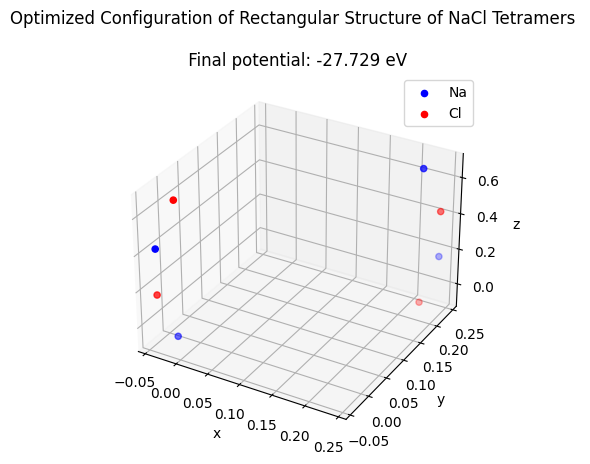

In [10]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x, y, z = cluster.positions[:, 1], cluster.positions[:, 1], cluster.positions[:, 0]

# Scatter plot for Na
ax.scatter(x[charges > 0], y[charges > 0], z[charges > 0], c='b', label='Na')

# Scatter plot for Cl
ax.scatter(x[charges < 0], y[charges < 0], z[charges < 0], c='r', label='Cl')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Set the label for the plot
ax.set_title("Optimized Configuration of Rectangular Structure of NaCl Tetramers \n\n Final potential: -27.729 eV")

# Add legends
ax.legend()

plt.show()


Another interactive code for 3D view

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

charges = cluster.charges
x, y, z = cluster.positions[:, 2], cluster.positions[:, 0], cluster.positions[:, 1]

# Create a trace for Na (positive charges)
trace_na = go.Scatter3d(
    x=x[charges > 0],
    y=y[charges > 0],
    z=z[charges > 0],
    mode='markers',
    marker=dict(color='blue', colorscale='aggrnyl', cmin=min(charges), cmax=max(charges)),
    name='Na'
)

# Create a trace for Cl (negative charges)
trace_cl = go.Scatter3d(
    x=x[charges < 0],
    y=y[charges < 0],
    z=z[charges < 0],
    mode='markers',
    marker=dict(color='red', colorscale='aggrnyl', cmin=min(charges), cmax=max(charges)),
    name='Cl'
)

fig = go.Figure(data=[trace_na, trace_cl])
fig.update_layout(scene=dict(xaxis_title='X-Axis', yaxis_title='Y-Axis', zaxis_title='Z-Axis'))
fig.update_layout(title_text="Optimized Configuration of Rectangular Structure of NaCl Tetramers with final potential of -27.729 eV")
fig.show()


# Run the simulation for the Hexagonal Shaped configuration

<img src="https://github.com/Mosaddeq107/23-Homework7G5/blob/main/Images/hexagonal_right.png?raw=true" style="height:300px" />





### Guessing and setting the initial position of Na and Cl

In [4]:
a = 0.2

r_na = np.array([ [-a,0,0], [1.1*a,0,0], [2.1*a,0,-0.5*a], [0.3*a,0.1*a,-a] ])
r_cl = np.array([ [0,-a,0], [2.1*a,0,0], [1.1*a,0,-0.5*a], [0,a,0] ])

cluster = Cluster(r_na, r_cl)
vals_init = cluster.get_vals()
print('initial Na positions:\n', r_na)
print('initial Cl positions:\n', r_cl)
print('initial positions flattened shape:\n', vals_init )
print('initial V  :', cluster.V() )

initial Na positions:
 [[-0.2   0.    0.  ]
 [ 0.22  0.    0.  ]
 [ 0.42  0.   -0.1 ]
 [ 0.06  0.02 -0.2 ]]
initial Cl positions:
 [[ 0.   -0.2   0.  ]
 [ 0.42  0.    0.  ]
 [ 0.22  0.   -0.1 ]
 [ 0.    0.2   0.  ]]
initial positions flattened shape:
 [-0.2   0.    0.    0.22  0.    0.    0.42  0.   -0.1   0.06  0.02 -0.2
  0.   -0.2   0.    0.42  0.    0.    0.22  0.   -0.1   0.    0.2   0.  ]
initial V  : 60.430145184856165


In [5]:
res = scipy.optimize.minimize( fun=cluster, x0=vals_init, tol=1e-3, method="CG")
cluster.set_vals(res.x)  # For some reason, "minimize" is not updating the class at the last iteration
print ("Final optimized cluster positions")
print(cluster.positions)
print("Final potential:", res.fun)

Final optimized cluster positions
[[ 0.01925307  0.07906049  0.07177112]
 [ 0.19058656 -0.11603468  0.3240974 ]
 [ 0.09435918  0.12098401 -0.42413406]
 [ 0.26577277 -0.07402928 -0.1717912 ]
 [ 0.23519174 -0.10129502  0.07850662]
 [ 0.00364829  0.04009854  0.31826605]
 [ 0.28129588 -0.03515154 -0.41830544]
 [ 0.04983264  0.10632953 -0.17852468]]
Final potential: -27.729842270467213


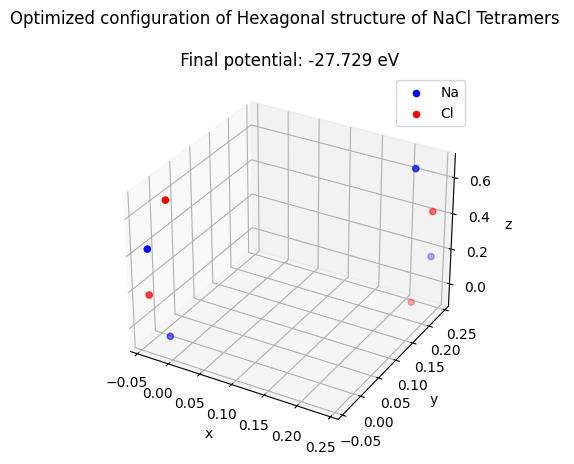

In [12]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

charges = cluster.charges
x, y, z = cluster.positions[:, 1], cluster.positions[:, 1], cluster.positions[:, 0]

# Scatter plot for Na
ax.scatter(x[charges > 0], y[charges > 0], z[charges > 0], c='b', label='Na')

# Scatter plot for Cl
ax.scatter(x[charges < 0], y[charges < 0], z[charges < 0], c='r', label='Cl')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Set the label for the plot
ax.set_title('Optimized configuration of Hexagonal structure of NaCl Tetramers \n\n Final potential: -27.729 eV')

# Add legends
ax.legend()

plt.show()


In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

charges = cluster.charges
x, y, z = cluster.positions[:, 2], cluster.positions[:, 1], cluster.positions[:, 0]

# Create a trace for Na (positive charges)
trace_na = go.Scatter3d(
    x=x[charges > 0],
    y=y[charges > 0],
    z=z[charges > 0],
    mode='markers',
    marker=dict(color='blue', colorscale='aggrnyl', cmin=min(charges), cmax=max(charges)),
    name='Na'
)

# Create a trace for Cl (negative charges)
trace_cl = go.Scatter3d(
    x=x[charges < 0],
    y=y[charges < 0],
    z=z[charges < 0],
    mode='markers',
    marker=dict(color='red', colorscale='aggrnyl', cmin=min(charges), cmax=max(charges)),
    name='Cl'
)

fig = go.Figure(data=[trace_na, trace_cl])
fig.update_layout(scene=dict(xaxis_title='X-Axis', yaxis_title='Y-Axis', zaxis_title='Z-Axis'))
fig.update_layout(title_text="Optimized configuration of Hexagonal structure of NaCl Tetramers with the final potential of -27.729 eV")
fig.show()
